### Hydrogen

In [13]:
import os
import csv
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from qiskit_algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [14]:
optimizer = COBYLA
optimizer_str = 'COBYLA'

##### Functions

In [15]:
def vqe_distance(solver, vqe, distance):
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    mapper = JordanWignerMapper()
    fermionic_op = problem.hamiltonian.second_q_op()
    qubit_op = mapper.map(fermionic_op)

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)

    """
    vqe.estimator = noisy_estimator
    """

    result_vqe = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    
    return (hamiltonian, result, result_vqe)

In [16]:
def save_csv(distances, energies, energies_vqe, path):

    folder = path.split('/')[0]
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    with open(path, mode='w', newline='') as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(['distance', 'energy', 'energy_vqe'])
        for x, y, z in zip(distances, energies, energies_vqe):
            escritor_csv.writerow([x, y, z])

In [17]:
# Configura Matplotlib para usar la fuente Times New Roman
# rc('font', size=12, **{'family': 'serif', 'serif': ['Times New Roman']})

def save_plt(distances, energies, energies_vqe, path, shots):

    folder = path.split('/')[0]
    if not os.path.exists(folder):
        os.makedirs(folder)

    plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
    plt.plot(distances, energies_vqe, marker='', linestyle='--', label=f'$shots$ = {shots}')
    plt.xlabel('$d$ / Å')
    plt.ylabel('$E$ / Hartree')
    # plt.title('Hydrogen Molecule')
    plt.legend()
    plt.savefig(path)
    plt.show()

##### Code

In [18]:
solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
    )

In [19]:
driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    )

problem = driver.run()
mapper = JordanWignerMapper()

fermionic_op = problem.hamiltonian.second_q_op()

# define ansatz and optimizer
ansatz = TwoLocal(fermionic_op.num_spin_orbitals, rotation_blocks="ry", entanglement_blocks="cz")

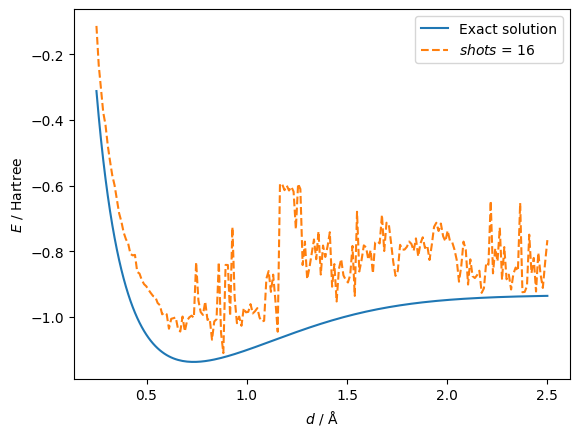

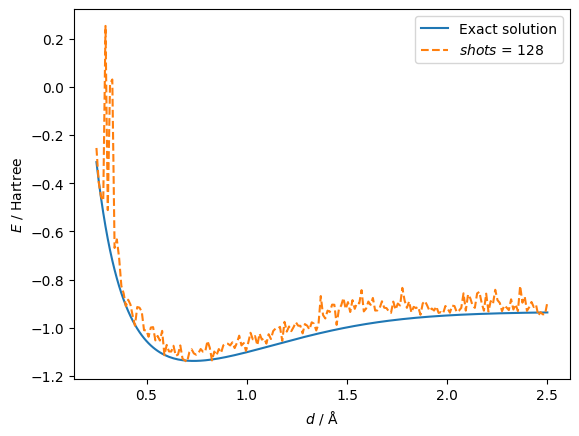

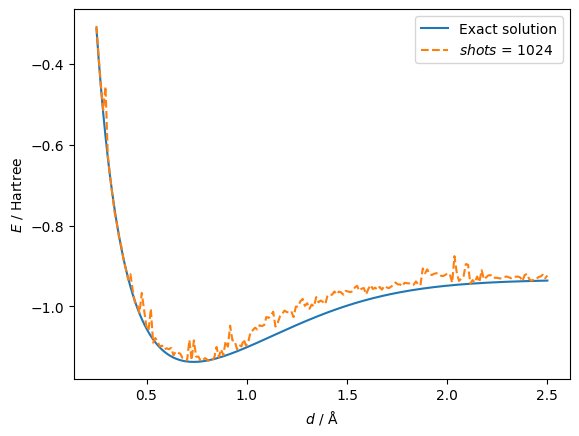

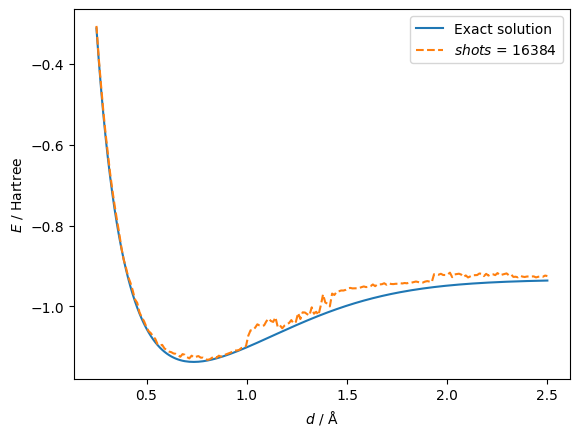

In [20]:
distances = np.linspace(0.25, 2.5, 200)
shots_list = [16, 128, 1024, 16384]

for shots in shots_list:
    energies = []
    energies_vqe = []

    seed = 170
    algorithm_globals.random_seed = seed

    noiseless_estimator = AerEstimator(
        run_options={"seed": seed, "shots": shots},
        transpile_options={"seed_transpiler": seed},
    )

    vqe = VQE(noiseless_estimator, ansatz, optimizer=optimizer())
    vqe.initial_point = np.zeros(16)
    
    for distance in distances:
        
        hamiltonian, result, result_vqe = vqe_distance(solver, vqe, distance)

        energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
        energies_vqe.append(result_vqe.eigenvalue.real + hamiltonian.nuclear_repulsion_energy)

    path_csv = f'results_{optimizer_str}/shots={shots}.csv'
    path_plt = f'results_{optimizer_str}/shots={shots}.png'
    
    save_csv(distances, energies, energies_vqe, path_csv)
    save_plt(distances, energies, energies_vqe, path_plt, shots)